In [1]:
# this file calculates raster statistics of a specified polygon. 

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path

In [2]:
# identify working directories for exports
current_dir = os.getcwd() # current directory for scripts/git
parent_dir = os.path.dirname(current_dir) # one level up for exports

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 591,
 'height': 663,
 'count': 234,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(29.99981, 0.0, 766641.15,
        0.0, -30.0, 6997860.133)}

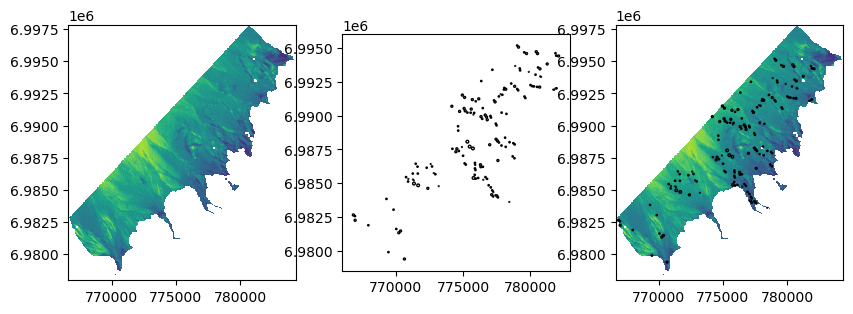

In [57]:
## READ IN DATA 

#locate files
image_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip-surfaces_BCET.tif'
polygons_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\SPOTS_1_aged.shp'

# read in files
image = rasterio.open(image_file, mode = 'r')
polygons = gpd.read_file(polygons_file)

# plot as check
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
show(image, ax = ax1)

polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'black')

show(image, ax = ax3)
polygons.plot(ax = ax3, facecolor = 'none', edgecolor = 'black')

# image metadata
image.meta

In [58]:
## Calculate raster statistics of each polygon i.e. fan, for each band 
# see for zonal_stats function info: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics

meta = image.meta # variable for accessing meta data
affine = image.transform # record affine for stats below

# choose statistics to calculate
stats = ['mean', 'std'] # see default options from zonal_stats

# create empty array to fill with polygon attributes and new raster stats data from each fan, for each band
pix_stat_array = np.empty((meta['count'], len(polygons)), dtype = dict) # dtype only works as dict, list, or object (?)

# calculate zonal statistics    
for i in range(meta['count']): # for i in range of bands
    ii = i + 1
    image_array = image.read(ii) # read image at that band
    
    # calcuate new statistics and fill empty array with existing attributes and these.  
    pix_stat_array[i] = rasterstats.zonal_stats(polygons, image_array, affine = affine, # image array is unique!
                                                stats = stats, # new stats 
                                                nodata = 0.0,
                                                geojson_out = True, # keep existing polygon attributes
                                                all_touched = False) # include edge pix? False means no

In [60]:
# check for new statistics!
pix_stat_array[0][0]['properties'] #array[band][unique fan]['properties i.e. attributes]

{'FIRST_Unit': 'Q3',
 'FIRST_fan': 'Co',
 'FIRST_uniq': '130CoQ3',
 'Id': 0,
 'Join_Count': 1,
 'MEAN_abs_a': 107.699996948,
 'MEAN_age_n': 1.0,
 'MEAN_age_s': 22.1000003815,
 'SUM_area': 2676195.0,
 'TARGET_FID': 0,
 'unique': '130CoQ3',
 'mean': 21119.666666666668,
 'std': 3392.6727909815686}

In [61]:
# extract statistics from array, and create dataframe 
# 1. extract existing properties stores in the polygons e.g. age, unique id, etc.
# 2. create base dataframe, drop first set of new stats 
# 3. Loop through all unique fan surfaces i.e. polygons, by band and extract new statistics into lists
# 4. Append new stats list to the dataframe

properties_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    properties_list.append(pix_stat_array[0][jj]['properties']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

df = pd.DataFrame(properties_list) # create dataframe from list
df = df.drop(columns=stats) # drop the first 


for ii in range(meta['count']):
    mean_pix_list = []
    std_pix_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
    
    df['B{}_mean'.format(ii + 1)] = mean_pix_list
    df['B{}_std'.format(ii + 1)] = std_pix_list
        
df.head()

C:\Users\htccr\AppData\Local\Temp/ipykernel_71332/3549686836.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['B{}_std'.format(ii + 1)] = std_pix_list
C:\Users\htccr\AppData\Local\Temp/ipykernel_71332/3549686836.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['B{}_mean'.format(ii + 1)] = mean_pix_list


,FIRST_Unit,FIRST_fan,FIRST_uniq,Id,Join_Count,MEAN_abs_a,MEAN_age_n,MEAN_age_s,SUM_area,TARGET_FID,...,B230_mean,B230_std,B231_mean,B231_std,B232_mean,B232_std,B233_mean,B233_std,B234_mean,B234_std
0,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,0,...,28666.888889,1412.731982,29106.444444,3080.559585,34530.333333,5717.624895,33978.000000,4682.886384,23489.000000,1771.611507
1,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,1,...,32616.263158,1854.321179,32089.157895,2368.452465,38661.210526,3941.601152,33326.052632,5186.649456,15469.736842,2457.694873
2,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,2,...,31905.950000,1533.320269,30460.300000,2681.559529,35415.300000,4315.507793,30163.850000,5347.677386,15905.350000,2553.803620
3,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,3,...,31857.111111,2652.630411,33467.333333,2564.264634,37945.000000,3547.938400,32823.111111,5615.107982,17565.333333,1411.258146
4,Q3,Co,130CoQ3,0,1,107.699997,1.0,22.1,2676195.0,4,...,32949.625000,1501.710353,32439.500000,3168.371388,36138.375000,3119.029213,27625.625000,5044.378702,15155.125000,2451.782843


In [88]:
# Create 'clean' dataframe without modern (i.e. age = 0), or rock avalanch "Av" units. 
clean = df.drop(df[df.Unit == "Modern"].index)
clean = clean.drop(clean[clean.Unit == "Av"].index)


21

In [62]:
# Plot spectral signature as bands

#bands_only = df.drop(columns=['Unit', 'unique','age_n','age_sd','area','fan']) # drop specified columns
bands_only = df.drop(columns=['FIRST_Unit', 'FIRST_fan','FIRST_uniq','Id', 'Join_Count', 'MEAN_age_n', 'MEAN_age_s', 'SUM_area','TARGET_FID', 'unique']) # drop specified columns

bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

In [63]:
bands_only

,MEAN_abs_a,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,...,B225_mean,B226_mean,B227_mean,B228_mean,B229_mean,B230_mean,B231_mean,B232_mean,B233_mean,B234_mean
0,107.699997,21119.666667,20792.222222,21497.555556,20344.555556,22555.222222,22000.777778,22893.222222,22407.333333,22487.222222,...,31179.444444,29523.555556,28366.888889,29664.444444,28206.666667,28666.888889,29106.444444,34530.333333,33978.000000,23489.000000
1,107.699997,33722.368421,30862.368421,29243.157895,29810.157895,30783.105263,30569.052632,29911.105263,30007.894737,29694.000000,...,32308.684211,30994.842105,31070.894737,35079.315789,31051.421053,32616.263158,32089.157895,38661.210526,33326.052632,15469.736842
2,107.699997,30235.300000,28624.500000,29075.150000,27246.550000,28595.150000,28089.950000,28219.000000,28115.650000,27849.500000,...,31282.400000,29555.550000,28964.000000,33787.500000,29384.850000,31905.950000,30460.300000,35415.300000,30163.850000,15905.350000
3,107.699997,31995.666667,28600.333333,26880.444444,28789.888889,28767.555556,28513.444444,28905.111111,28807.222222,28137.111111,...,31743.888889,30628.666667,29348.222222,32839.666667,30330.444444,31857.111111,33467.333333,37945.000000,32823.111111,17565.333333
4,107.699997,28783.750000,27696.750000,27928.125000,27700.375000,28252.125000,27779.750000,27986.625000,27000.875000,26977.375000,...,31019.125000,29575.125000,30765.375000,34216.875000,29578.375000,32949.625000,32439.500000,36138.375000,27625.625000,15155.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,160.265000,34747.833333,34663.888889,35581.166667,35695.388889,34641.777778,34029.333333,34325.500000,34306.277778,34605.166667,...,36757.833333,39078.666667,39181.055556,36637.000000,39309.000000,37318.611111,38827.333333,36779.277778,41729.944444,44355.055556
147,160.265000,37236.619048,38011.714286,38299.523810,38202.666667,37093.047619,36915.857143,36839.095238,36948.000000,36922.857143,...,37638.000000,38376.857143,39688.476190,36190.714286,39440.428571,37923.380952,38180.142857,40437.380952,34499.952381,31168.000000
148,160.265000,31626.285714,32983.476190,32677.904762,33058.523810,32041.380952,31634.000000,31746.619048,32002.476190,31923.857143,...,36107.238095,36777.857143,37620.190476,33609.809524,37351.571429,36756.809524,38091.380952,38619.238095,39437.952381,38342.476190
149,160.265000,32966.000000,35583.625000,34181.875000,34868.375000,34100.375000,33525.000000,34056.125000,34274.000000,34119.500000,...,35105.375000,36458.000000,37017.375000,34261.375000,37718.875000,35375.125000,37126.750000,40030.125000,39338.625000,42469.000000


In [64]:
# Group rows of same age (e.g. 0.0) and take mean
# I will likley have to rewrite this code to sample every SPOT seperatly, then group all the SPOTS together based on the uniqueID. This way we can carry standard deviations though. 
#bands = bands_only.groupby(['abs_age'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 
bands = bands_only.groupby(['MEAN_abs_a'], dropna = False).mean() # group rows, take mean of variables, and also sorts by group value 

ages = np.array(bands.index.values.astype(float))
ages = np.round(ages, 2)

# extract ages index for plotting
band_name = np.array(bands.columns.values)

In [23]:
bands

,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,B10_mean,...,B225_mean,B226_mean,B227_mean,B228_mean,B229_mean,B230_mean,B231_mean,B232_mean,B233_mean,B234_mean
MEAN_abs_a,,,,,,,,,,,,,,,,,,,,,
0.000000,0.094431,0.086457,0.085404,0.091940,0.097304,0.104483,0.110642,0.113848,0.115613,0.120870,...,0.201922,0.216950,0.165194,0.207385,0.220050,0.213191,0.202517,0.169076,0.384560,0.219300
3.370000,0.057801,0.053855,0.053232,0.059369,0.061167,0.067429,0.073002,0.076890,0.078025,0.082132,...,0.163835,0.179903,0.146632,0.159331,0.188453,0.179268,0.172468,0.159276,0.401248,0.225039
5.106670,0.072765,0.066674,0.066588,0.070418,0.074690,0.080936,0.086254,0.088369,0.089616,0.093729,...,0.160978,0.173707,0.133097,0.158380,0.173917,0.164599,0.156518,0.125943,0.182775,0.198474
5.300000,0.092227,0.082866,0.081469,0.088029,0.094030,0.101473,0.107753,0.110492,0.112162,0.118241,...,0.205819,0.221552,0.167301,0.215117,0.223957,0.221629,0.212404,0.186490,0.515269,0.209583
5.400000,0.076642,0.071957,0.070605,0.075484,0.079196,0.085411,0.090388,0.093246,0.094911,0.099380,...,0.184839,0.201802,0.156476,0.182832,0.206050,0.191640,0.186225,0.149547,0.451069,0.233331
6.250000,0.070817,0.064824,0.061789,0.068666,0.073929,0.079542,0.085074,0.088541,0.090821,0.094824,...,0.188378,0.203191,0.160488,0.188788,0.207504,0.196182,0.200407,0.165397,0.235890,0.254648
7.690000,0.076925,0.070836,0.069845,0.074542,0.078468,0.084571,0.090096,0.092508,0.094708,0.099349,...,0.182452,0.199924,0.153759,0.179065,0.203274,0.190333,0.184044,0.152198,0.415573,0.219636
11.330000,0.082160,0.074991,0.074242,0.079404,0.087158,0.094565,0.101060,0.103533,0.105906,0.111389,...,0.194896,0.209746,0.160956,0.205851,0.211228,0.205252,0.197000,0.181677,0.469390,0.155903
16.450001,0.064609,0.060843,0.059544,0.064532,0.066937,0.073153,0.078707,0.081898,0.083770,0.087749,...,0.175319,0.188734,0.147926,0.167479,0.195282,0.182018,0.176797,0.149904,0.390068,0.205463


In [65]:
# normalize data
norm_across_band = (bands.T - bands.T.mean())/bands.T.std()

norm_same_band = (bands - bands.mean())/bands.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
norm_same_band_across = (norm_same_band.T - norm_same_band.T.mean())/norm_same_band.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

#scaled01 = (norm_same_band_across - norm_same_band_across.min())/(norm_same_band_across.max() - norm_same_band_across.min()) # scale to 0 to 1 range, seems incorrect

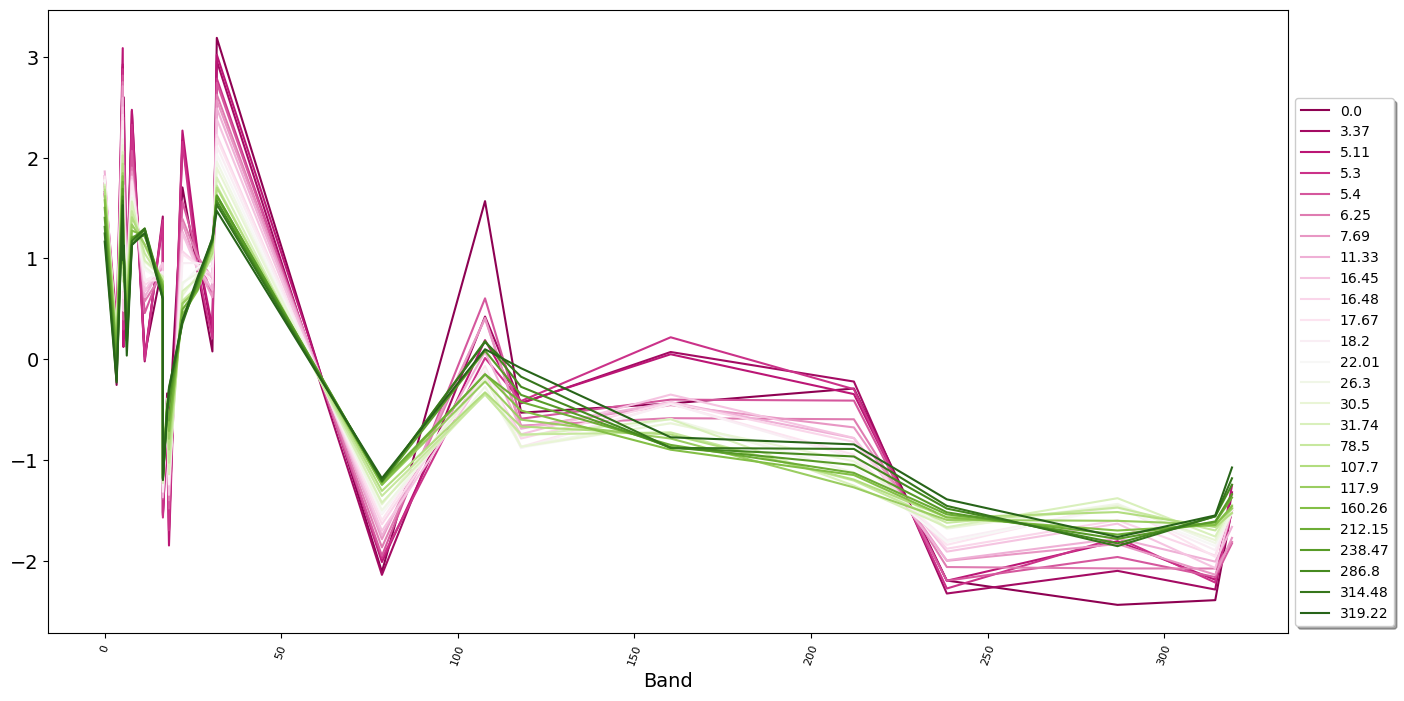

In [66]:
N = len(bands) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(norm_same_band_across.iloc[i], label = ages[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

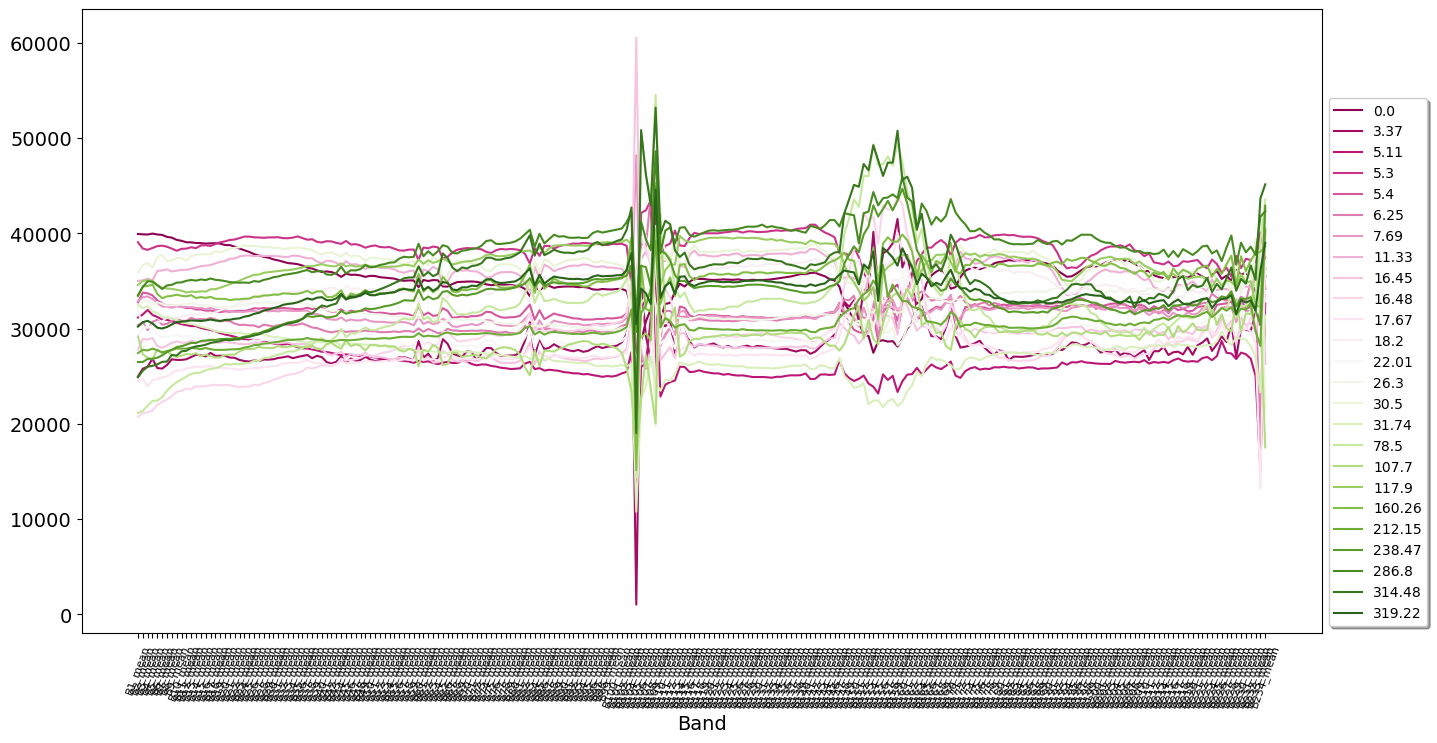

In [78]:
normed = (bands.T - bands.T.mean())/bands.T.std()

N = len(bands) # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(bands.iloc[i], label = ages[i]) # for i in range of objects, plot x,y
    
plt.xlim()

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [35]:
# Export final dataframe
export = norm_same_band_across # choose df to export

export.to_csv(parent_dir + '\outputs\\tester.csv', header = True) # '\selected_folder\\filename.file-type'

In [ ]:
# spot sample and clean up variance
# remove mean and create anomalies
# Use PCs
# extract ages as an array and do plt.plot(PCs[:,kk], ages)

# reconstruct the new data using the first few PCs of model-built data, nit neccisarily the index. 

In [ ]:
# KEEP FOR EXAMPLE/ SAFE KEEPING

In [ ]:
N = 28 # number of objects to plot i.e. color cycle count

plt.rcParams["figure.figsize"] = [16,9] # fig size
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.PiYG(np.linspace(0,1,N))) # colors to cycle through, choose default like 'viridis' or 'PiYG'

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(data[i], label = data.index.values.astype(float)[i]) # for i in range of objects, plot x,y

#plt.legend(loc = 'right')
plt.xlabel('Band', fontsize = 14)
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.yticks(fontsize = 14)

# cutum legend location
# get legend location
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          fancybox=True, shadow=True, ncol=1)

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

In [ ]:
# re-run itrative list but just collecting band information

age_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    age_list.append(pix_stat_array[0][jj]['properties']['abs_age']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

bands_only = pd.DataFrame({'age': age_list}) # create dataframe from list


for ii in range(meta['count']):
    mean_pix_list = []
    #std_pix_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        #std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
    
    bands_only['B{}_mean'.format(ii + 1)] = mean_pix_list
    #df2['B{}_std'.format(ii + 1)] = std_pix_list
        
bands_only = bands_only.sort_values('age', axis=0, ascending=True) # sort dataframe by age
bands_only['age'] = round(bands_only['age'], 2) # round ages to 2 sig figs
